In [1]:
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa

import matplotlib.pyplot as plt
import seaborn as sns

import basics

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
filenames = basics.get_and_shuffle_filenames("./recordings")

print(filenames[:5])

['./recordings/2_jackson_13.wav', './recordings/6_george_34.wav', './recordings/7_george_5.wav', './recordings/1_yweweler_21.wav', './recordings/2_george_42.wav']


In [3]:
X_unfiltered = [(file_path, basics.decode_audio(file_path)) for file_path in filenames]

# to remove outliers 
max_length = basics.get_max_length2(X_unfiltered, 1)
print(max_length)

4608


In [4]:
X_full = [] # padded X values 0-7
y_full = []

numbers = [0] * 8

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = basics.get_label(file_path)
    signal_length = audio.shape[0]
    
    if y_val > 7:
        continue
    if signal_length > max_length:
        numbers[y_val] += 1
        continue
        
    x_val = np.pad(
        x_val, (0, max_length - signal_length), 
        'constant', constant_values=(0, 0))

    x_spect = basics.spect(x_val, max_length)
    x_spect = x_spect.flatten()

    X_full.append(x_spect)
    y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

num_samples, sample_w = X_full.shape
print(num_samples)
print(sample_w)

print(y_full[:10])

2078
2304
[2 6 1 2 6 6 4 3 2 4]


In [5]:
# dropped outliers
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          84
1          25
2          16
3          29
4          21
5          41
6          70
7          36
322


In [6]:
# normalize data
X_full = basics.normalize_arr(X_full)

# partition into 80:10:10
partitions = basics.split_full(X_full, y_full)

X_train, y_train = partitions[0]
X_val, y_val = partitions[1]
X_test, y_test = partitions[2]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 1656
Validation set size 207
Test set size 215


In [7]:
# INPUTS ARE NORMALIZED

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Reshape((128, 18, 1), input_shape=(sample_w,)))

model.add(tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=(128, 18, 1)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.AveragePooling2D(2,2))

model.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.AveragePooling2D(2,2))
 
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.15))    
model.add(tf.keras.layers.Dense(40, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 18, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 125, 15, 32)       544       
                                                                 
 dropout (Dropout)           (None, 125, 15, 32)       0         
                                                                 
 average_pooling2d (AverageP  (None, 62, 7, 32)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 4, 16)         8208      
                                                                 
 dropout_1 (Dropout)         (None, 59, 4, 16)         0         
                                                        

2022-05-07 19:56:54.092091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [9]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Epoch 1/30
52/52 [==============================] - 2s 32ms/step - loss: 1.9285 - accuracy: 0.2621 - val_loss: 1.6642 - val_accuracy: 0.4348
Epoch 2/30
52/52 [==============================] - 2s 29ms/step - loss: 1.3251 - accuracy: 0.5175 - val_loss: 1.0215 - val_accuracy: 0.6522
Epoch 3/30
52/52 [==============================] - 2s 29ms/step - loss: 0.9528 - accuracy: 0.6655 - val_loss: 0.7855 - val_accuracy: 0.7343
Epoch 4/30
52/52 [==============================] - 2s 29ms/step - loss: 0.7775 - accuracy: 0.7216 - val_loss: 0.6843 - val_accuracy: 0.7778
Epoch 5/30
52/52 [==============================] - 2s 29ms/step - loss: 0.6623 - accuracy: 0.7645 - val_loss: 0.5829 - val_accuracy: 0.8068
Epoch 6/30
52/52 [==============================] - 1s 28ms/step - loss: 0.6125 - accuracy: 0.7917 - val_loss: 0.5413 - val_accuracy: 0.8357
Epoch 7/30
52/52 [==============================] - 1s 28ms/step - loss: 0.4922 - accuracy: 0.8309 - val_loss: 0.4816 - val_accuracy: 0.8406
Epoch 8/30
52

In [10]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.2471 - accuracy: 0.9256


[0.2471337616443634, 0.9255813956260681]

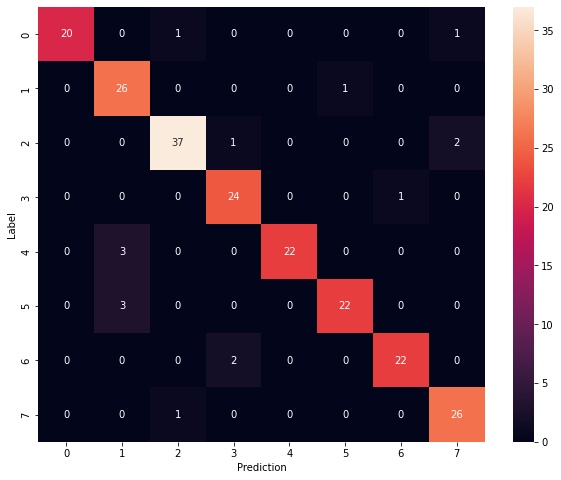

In [11]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(8))

confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=all_labels, yticklabels=all_labels, annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [12]:
model.save("v12.h5")